
# Quadratic Discriminant Analysis (QDA): Theory, Implementation, and Visualization

This notebook covers the mathematics of QDA, a from‑scratch implementation, scikit‑learn usage, and visualizations of decision boundaries.



## 1. Overview and Bayes’ Theorem

We start from **Bayes’ theorem** for a class label $y \in \{1,\ldots,C\}$ and a feature vector $\mathbf{x} = (x_1,\ldots,x_d)$ as follows:

$$
P(y \mid \mathbf{x}) = \frac{P(\mathbf{x}\mid y)\,P(y)}{P(\mathbf{x})}
\;\propto\;
P(\mathbf{x}\mid y)\,P(y).
$$

In **Quadratic Discriminant Analysis (QDA)** we assume **class‑conditional Gaussians** **with class‑specific covariances**:
$$
p(\mathbf{x}\mid y=c) = \mathcal{N}\!\bigl(\mathbf{x}\,;\,\boldsymbol{\mu}_c,\ \boldsymbol{\Sigma}_c\bigr),
\qquad
P(y=c)=\pi_c,\quad \sum_{c=1}^C \pi_c=1.
$$
Because each class has its own covariance $\boldsymbol{\Sigma}_c$, the resulting discriminant functions are **quadratic** in $\mathbf{x}$, allowing **curved decision boundaries**.



## 2. Gaussian Class‑Conditional Model and Discriminant

The multivariate Gaussian density is
$$
\mathcal{N}(\mathbf{x};\boldsymbol{\mu},\boldsymbol{\Sigma}) =
\frac{1}{(2\pi)^{d/2}\ |\boldsymbol{\Sigma}|^{1/2}}
\exp\!\left(-\tfrac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu})\right).
$$

Taking logs and ignoring the evidence $P(\mathbf{x})$ (which is common to all classes), the **log‑posterior up to a constant** for class $c$ is
$$
g_c(\mathbf{x})
= \log p(\mathbf{x}\mid y=c) + \log \pi_c
= -\frac{1}{2}\log\!\big|\boldsymbol{\Sigma}_c\big|
-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu}_c)^\top \boldsymbol{\Sigma}_c^{-1} (\mathbf{x}-\boldsymbol{\mu}_c)
+ \log \pi_c + \text{const}.
$$

Expanding the quadratic term shows that $g_c(\mathbf{x})$ is a quadratic function of $\mathbf{x}$, hence the name **Quadratic Discriminant**. The prediction rule is
$$
\hat{y} = \arg\max_{c \in \{1,\ldots,C\}} g_c(\mathbf{x}).
$$



## 3. Parameter Estimation (MLE)

Given a labeled dataset $\{(\mathbf{x}_i,y_i)\}_{i=1}^n$, with $n_c$ samples in class $c$, the **maximum likelihood estimates** are
$$
\hat{\pi}_c = \frac{n_c}{n},\qquad
\hat{\boldsymbol{\mu}}_c = \frac{1}{n_c}\sum_{i: y_i=c} \mathbf{x}_i,\qquad
\hat{\boldsymbol{\Sigma}}_c = \frac{1}{n_c}\sum_{i: y_i=c} (\mathbf{x}_i-\hat{\boldsymbol{\mu}}_c)(\mathbf{x}_i-\hat{\boldsymbol{\mu}}_c)^\top.
$$

In practice, one may prefer a **regularized** covariance to improve stability, e.g.
$$
\hat{\boldsymbol{\Sigma}}_c^{(\lambda)} = (1-\lambda)\,\hat{\boldsymbol{\Sigma}}_c + \lambda\,\alpha\,\mathbf{I},
\qquad \lambda \in [0,1],
$$
where $\alpha$ is a scale (e.g., the average variance). When all classes share the same covariance, QDA reduces to **LDA**, yielding linear boundaries.



## 4. QDA From Scratch (NumPy)

Below we implement QDA directly from the formulas above. We will then visualize decision boundaries in 2D.


In [1]:

import numpy as np
from numpy.linalg import slogdet, inv
from dataclasses import dataclass

@dataclass
class QDA:
    reg_lambda: float = 0.0  # [0,1] shrinkage toward alpha*I
    random_state: int = 42

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        n, d = X.shape
        self.means_ = {}
        self.covs_ = {}
        self.priors_ = {}
        # Per-class stats
        for c in self.classes_:
            Xc = X[y == c]
            nc = Xc.shape[0]
            mu = Xc.mean(axis=0)
            # ML covariance (biased) consistent with the derivation above
            diff = Xc - mu
            Sigma = (diff.T @ diff) / nc
            # Regularization (optional)
            if self.reg_lambda > 0.0:
                alpha = np.trace(Sigma) / Sigma.shape[0]
                Sigma = (1 - self.reg_lambda) * Sigma + self.reg_lambda * alpha * np.eye(d)
            self.means_[c] = mu
            self.covs_[c] = Sigma
            self.priors_[c] = nc / n
        return self

    def _log_gaussian(self, X, mu, Sigma):
        # Compute log N(x; mu, Sigma) up to additive constant across classes
        X = np.atleast_2d(X)
        d = X.shape[1]
        sign, logdet = slogdet(Sigma)
        if sign <= 0:
            # Numerical fallback: add a tiny jitter
            eps = 1e-9
            Sigma = Sigma + eps * np.eye(d)
            sign, logdet = slogdet(Sigma)
        invS = inv(Sigma)
        diff = X - mu
        quad = np.sum(diff @ invS * diff, axis=1)  # row-wise Mahalanobis^2
        return -0.5 * (logdet + quad)

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        scores = np.zeros((X.shape[0], len(self.classes_)))
        for j, c in enumerate(self.classes_):
            mu = self.means_[c]
            Sigma = self.covs_[c]
            logp = self._log_gaussian(X, mu, Sigma)
            scores[:, j] = logp + np.log(self.priors_[c])
        return scores

    def predict(self, X):
        scores = self.decision_function(X)
        idx = np.argmax(scores, axis=1)
        return self.classes_[idx]

    def predict_proba(self, X):
        scores = self.decision_function(X)
        # Softmax for posterior probabilities
        scores = scores - scores.max(axis=1, keepdims=True)
        exp_s = np.exp(scores)
        return exp_s / exp_s.sum(axis=1, keepdims=True)



## 5. Visualization on 2D Toy Data

We generate two classes with different covariance matrices to illustrate the **curved** decision boundary of QDA.


From-scratch QDA accuracy: 0.9904761904761905
Confusion matrix:
 [[104   1]
 [  1 104]]
Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       105
           1       0.99      0.99      0.99       105

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



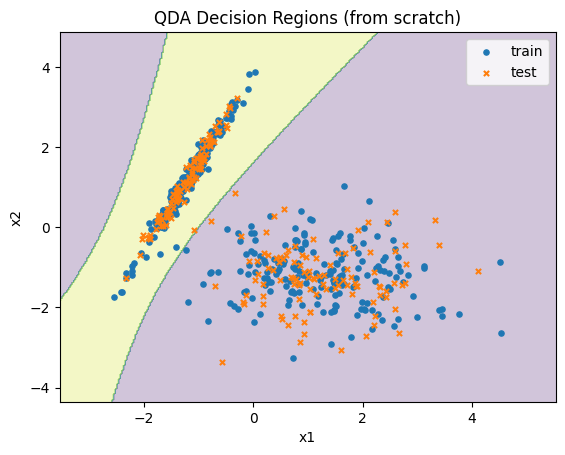

In [2]:

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a 2D dataset with class-wise covariance differences
X, y = make_classification(
    n_samples=600, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=1.2, random_state=7
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=7, stratify=y)

qda = QDA(reg_lambda=0.05).fit(X_train, y_train)
y_pred = qda.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("From-scratch QDA accuracy:", acc)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

# Decision boundary plot
x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = qda.predict(grid).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.25)
plt.scatter(X_train[:,0], X_train[:,1], s=14, label="train")
plt.scatter(X_test[:,0], X_test[:,1], s=14, marker="x", label="test")
plt.title("QDA Decision Regions (from scratch)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.show()



## 6. Comparison with scikit‑learn

We compare against `sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis`.


scikit-learn QDA accuracy: 0.9904761904761905


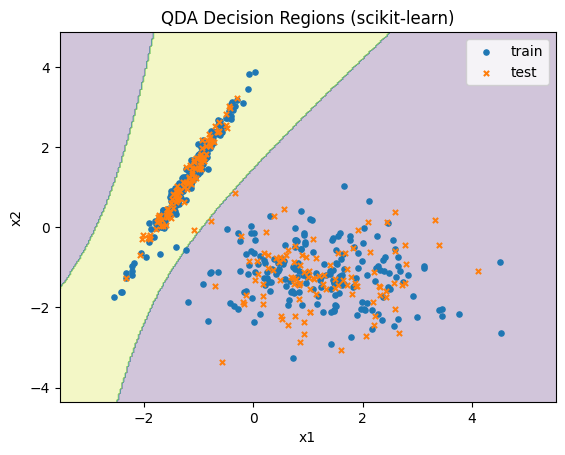

In [3]:

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

sk_qda = QuadraticDiscriminantAnalysis(reg_param=0.05)
sk_qda.fit(X_train, y_train)
y_pred_sk = sk_qda.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred_sk)

print("scikit-learn QDA accuracy:", acc_sk)

# Decision boundary for sklearn
Z_sk = sk_qda.predict(grid).reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z_sk, alpha=0.25)
plt.scatter(X_train[:,0], X_train[:,1], s=14, label="train")
plt.scatter(X_test[:,0], X_test[:,1], s=14, marker="x", label="test")
plt.title("QDA Decision Regions (scikit-learn)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.show()



## 7. Decision Boundary Form

For two classes $c \in \{0,1\}$, the decision boundary solves $g_1(\mathbf{x}) = g_0(\mathbf{x})$:
$$
-\tfrac{1}{2}\log|\boldsymbol{\Sigma}_1| - \tfrac{1}{2}(\mathbf{x}-\boldsymbol{\mu}_1)^\top \boldsymbol{\Sigma}_1^{-1}(\mathbf{x}-\boldsymbol{\mu}_1) + \log \pi_1
=
-\tfrac{1}{2}\log|\boldsymbol{\Sigma}_0| - \tfrac{1}{2}(\mathbf{x}-\boldsymbol{\mu}_0)^\top \boldsymbol{\Sigma}_0^{-1}(\mathbf{x}-\boldsymbol{\mu}_0) + \log \pi_0.
$$
Collecting terms yields a **quadratic form** in $\mathbf{x}$:
$$
\mathbf{x}^\top \mathbf{A}\,\mathbf{x} + \mathbf{b}^\top \mathbf{x} + c = 0,
$$
with $\mathbf{A}$ symmetric. When $\boldsymbol{\Sigma}_0=\boldsymbol{\Sigma}_1$, the quadratic terms cancel and the boundary is linear (LDA case).



## 8. Practical Notes

1. **Numerical stability:** If $\boldsymbol{\Sigma}_c$ is near‑singular (e.g., $d$ close to $n_c$), add a small diagonal jitter or use shrinkage (the `reg_lambda` in our implementation, or `reg_param` in scikit‑learn).
2. **Scaling:** Standardizing features can improve conditioning of covariance estimates.
3. **Imbalanced classes:** Priors $\pi_c$ strongly affect boundaries; you may set them from data or domain knowledge.
4. **Connection to LDA:** Setting $\boldsymbol{\Sigma}_c\equiv\boldsymbol{\Sigma}$ for all $c$ recovers linear boundaries.



## 9. Bonus: Standardization and Cross‑Validation

Below, we evaluate QDA with and without standardization using $k$‑fold cross‑validation.


In [4]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

pipe_std = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis(reg_param=0.05))
pipe_raw = QuadraticDiscriminantAnalysis(reg_param=0.05)

scores_std = cross_val_score(pipe_std, X, y, cv=cv)
scores_raw = cross_val_score(pipe_raw, X, y, cv=cv)

print("CV accuracy with StandardScaler:", scores_std.mean(), "±", scores_std.std())
print("CV accuracy raw:", scores_raw.mean(), "±", scores_raw.std())


CV accuracy with StandardScaler: 0.9833333333333334 ± 0.012909944487358053
CV accuracy raw: 0.9883333333333333 ± 0.0040824829046386705
